# SIMPLIFIED MODEL 

The first simplified version of the model contemplates a grid where all of the agents are assigned a home. The agents can do some actions, regulated by the time of the model. The actions take them to particular locations inside the grid. They also receive an income every month, so the positions and wealth histogram distribution can be plotted using the data collection module in mesa. 

The idea is to generalize the model in order to work with any city, with the corresponding inputs and data in order to obtain which policies reduce povery the most in the city. 


In [6]:
import mesa
from mesa.space import MultiGrid

from typing import Dict, List, Tuple

class CityGrid(MultiGrid):
    """A grid representing a city with buildings.

    Attributes
    ----------
    locations : Dict[str, List[Tuple[int, int]]]
        Map of locations of buildings.

    """
    locations: Dict[str, List[Tuple[int, int]]]
    __busy_positions: List[Tuple[int, int]]
       
    def __init__(self, width: int, height: int, torus: bool, \
    locations: Dict[str, List[Tuple[int, int]]]) -> None:
        """Create a new city grid.

        Parameters
        ----------
        width : int
        height : int
        torus : bool
        locations : Dict[str, List[Tuple[int, int]]]
            Map of locations.

        Raises
        ------
        ValueError
            if the locations are not consistent.
        
        See Also
        --------
        mesa.space.MultiGrid

        """
        super().__init__(width, height, torus)
        self.__busy_positions = []
        self.__check_consistent_locations(width, height, locations)
        self.locations = locations


    def __check_consistent_locations(
        self,
        width: int,
        height: int,
        locations: Dict[str, List[Tuple[int, int]]]
    ) -> None:
        """Check that the locations are consistent with grid size and among
        themselves."""
        for l in locations.values():
            for x, y in l:
                if x<0 or x>width or y<0 or y>height:
                    raise ValueError(f"position ({x, y}) outside of grid \
                    dimensions")
                if (x, y) in self.__busy_positions:
                    raise ValueError(f"position ({x, y}) is already busy")
                self.__busy_positions.append((x, y))


    def is_busy(self, x: int, y: int) -> bool:
        """Check if some locations has a building of any type.

        Parameters
        ----------
        x : int
        y : int

        Returns
        -------
        bool
        
        """
        return (x, y) in self.__busy_positions
    

    def add_location(self, type: str, x: int, y:int) -> None:
        """Set a location as containing a building of some type.

        Parameters
        ----------
        type : str
        x : int
        y : int

        Raises
        ------
        ValueError
            If the input location is already busy.
            
        """
        if (x, y) in self.__busy_positions:
            raise ValueError(f"position ({x, y}) is already busy")
        try:
            self.locations[type].append((x, y))
        except KeyError:
            self.locations[type] = [(x, y)]
        self.__busy_positions.append((x, y))

locs = {
    'school': [(0, 1), (3, 3)],
    'hospital': [(1, 1)],
    'leisure': [(2, 4), (5, 5)],
    'houses': [(2, 3), (5, 3), (1, 2), (3, 4), (5, 6)],
    'work' : [(1, 0), (6, 6)]
}

class Apo_Agent(mesa.Agent):
    """An agent with BCN income."""
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 0
        self.home = None
        self.age = None
    
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.location, moore=True, include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        self.location = new_position
    
    def go_to_work(self):
        self.model.grid.move_agent(self, self.random.choice(self.model.locs['work']))

    def go_to_leisure(self):
        self.model.grid.move_agent(self, self.random.choice(self.model.locs['leisure']))
        
    def go_home(self):
        self.model.grid.move_agent(self, self.model.locs['houses'][self.unique_id])
    
    def step(self):
        print("Position of "+ str(self.unique_id) +" is " + str(self.pos))

class Apo_Model(mesa.Model):

    def __init__(self, N, width, height, wealth_list):
        self.num_agents = N
        self.locs = locs
        self.grid = CityGrid(width, height, False, locs) 
        self.wealth_list = wealth_list
        self.time_of_day = "morning"
        
        # Scheduler
        self.schedule = mesa.time.RandomActivation(self)
        
        # Create agents
        for i in range(self.num_agents):
            ag = Apo_Agent(i, self)
            self.schedule.add(ag)
            ag.wealth = 0 #wealth_list[i]
            ag.home = self.locs['houses'][i]
            #ag.age = self.
            
        # Initialize data collector
        self.datacollector = mesa.DataCollector(
            model_reporters={"Agent Positions": lambda m: [a.pos for a in m.schedule.agents]}, agent_reporters= {"Wealth": lambda a: a.wealth})

    def step(self):
        time = self.schedule.time % 24
        if time == 0: 
            for agent in self.schedule.agents:
                self.grid.place_agent(agent, agent.home)
        # Schedule agents to go to work in the morning
        if 0 < time < 8:
            for agent in self.schedule.agents:
                agent.go_to_work()
        
        # Schedule agents to go to leisure locations in the afternoon
        if 8 <= time < 16:
            for agent in self.schedule.agents:
                agent.go_to_leisure()
        
        # Schedule agents to go home at night
        else:
            for agent in self.schedule.agents:
                agent.go_home()

        #when a month has passed, mensuality is given to the agents

        if self.schedule.time % 672 == 0:
            for agent in self.schedule.agents:
                agent.wealth += self.wealth_list[agent.unique_id]

        # Collect agent positions
        self.datacollector.collect(self)
        #print(time)
        self.schedule.step()

import pandas as pd
import numpy as np

N = 5

income = pd.read_csv('OpenData/2020_renda_neta_mitjana_per_persona.csv')
monthly_wealth = np.array(income['Import_Euros']) / 12

model = Apo_Model(N, 10, 10, monthly_wealth)
for i in range(700):  #Una mica més d'un mes
    model.step()
        

Position of 0 is (2, 3)
Position of 1 is (5, 3)
Position of 4 is (5, 6)
Position of 2 is (1, 2)
Position of 3 is (3, 4)
Position of 3 is (3, 4)
Position of 0 is (2, 3)
Position of 2 is (1, 2)
Position of 4 is (5, 6)
Position of 1 is (5, 3)
Position of 2 is (1, 2)
Position of 4 is (5, 6)
Position of 0 is (2, 3)
Position of 1 is (5, 3)
Position of 3 is (3, 4)
Position of 3 is (3, 4)
Position of 2 is (1, 2)
Position of 1 is (5, 3)
Position of 0 is (2, 3)
Position of 4 is (5, 6)
Position of 1 is (5, 3)
Position of 4 is (5, 6)
Position of 0 is (2, 3)
Position of 2 is (1, 2)
Position of 3 is (3, 4)
Position of 4 is (5, 6)
Position of 3 is (3, 4)
Position of 2 is (1, 2)
Position of 1 is (5, 3)
Position of 0 is (2, 3)
Position of 3 is (3, 4)
Position of 4 is (5, 6)
Position of 2 is (1, 2)
Position of 0 is (2, 3)
Position of 1 is (5, 3)
Position of 4 is (5, 6)
Position of 0 is (2, 3)
Position of 3 is (3, 4)
Position of 2 is (1, 2)
Position of 1 is (5, 3)
Position of 4 is (2, 4)
Position of 0 is

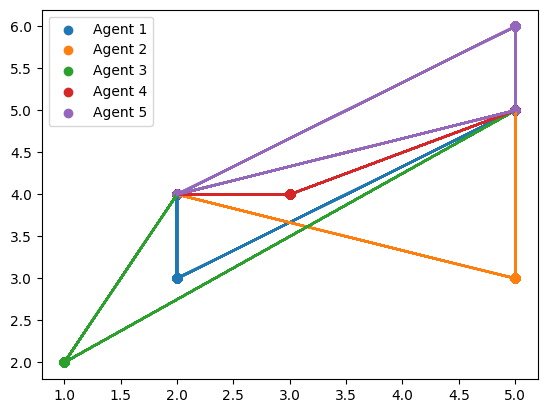

In [8]:
#POSITIONS PLOT
import matplotlib.pyplot as plt
N=5
positions = model.datacollector.get_model_vars_dataframe()

def extract_position(row, agent_index):
    return row['Agent Positions'][agent_index]

for i in range(N):
    positions[f'Agent {i+1}'] = positions.apply(lambda row: extract_position(row, i), axis=1)

fig, ax = plt.subplots()
for i in range(N):
    agent_col = f'Agent {i+1}'
    ax.scatter(positions[agent_col].apply(lambda x: x[0]), positions[agent_col].apply(lambda x: x[1]), label=agent_col)
    positions[f'Agent {i+1} X'] = [pos[i][0] for pos in positions['Agent Positions']]
    positions[f'Agent {i+1} Y'] = [pos[i][1] for pos in positions['Agent Positions']]

# each agent's trajectory
for i in range(N):
    ax.plot(positions[f'Agent {i+1} X'], positions[f'Agent {i+1} Y'])

ax.legend()
plt.show()

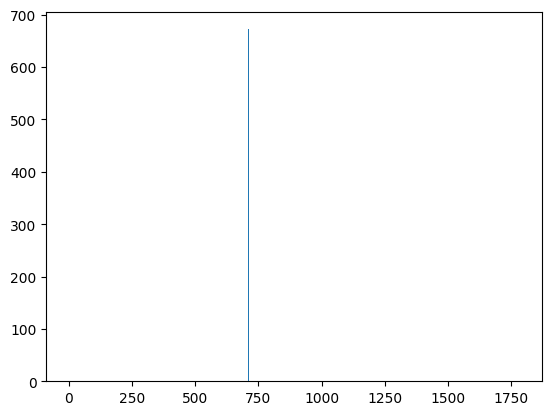

In [22]:
# WEALTH HISTOGRAM PLOT
wealth = model.datacollector.get_agent_vars_dataframe()
#wealth_onestep = wealth.xs(0)['Wealth']
#agent_wealth = wealth_onestep.xs(0)['Wealth']
all_wealth = []

for step in wealth.index.get_level_values('Step').unique():
    wealth_onestep = wealth.xs(step)['Wealth']
    for agent in model.schedule.agents:
        agent_wealth = wealth_onestep.loc[agent.unique_id]
        all_wealth.append(agent_wealth)

plt.hist(all_wealth, bins=range(int(max(all_wealth)) + 1))
plt.show()



# CITY MODEL WITH DISTRICTS


Now we are going to add to the city class a district Grid formulation in order to represent a few BCN districts: Sarrià-sant gervasi, Eixample, Les Corts i Gràcia. 

Let's place the model and agents in the districts. The new classes are: 
- *DistrictGrid*: represents grid of districts with buildings of different types, each districtGrid object contains a name to identify the district, a dictionary 'locations' to map the buildings to their locations on the grid, and a list __busy_positions to keep track of the positions occupied. 

- *CityModel*: represents a city as a collection of districts. Each CItyModel object contains a 'name' attribute to identify the city and a dictionary 'districts' that maps district names to their DistrictGrid objects. The __init__ method sets the name and districts attributes. It takes a collection of DistrictGrid objects as input and converts it into a dictionary that maps each district's name to its object using a dictionary comprehension.

The data for these particular districts taking a particular year is extracted from OPENDATA. Most of the data goes from 2015 to 2022, so at the end, we will be able to work with an up to 7 year duration model. 

- *Wealth*: Renda neta mitjana per persona dividida entre els 12 mesos de l'any i seleccionada per districtes.
- *Age* and *Gender*: Edats i sexe assignats segons les proporcions a cada districte. (Nombre de persones amb x edat de cert sexe per districtes). L'*status* s'assigna a partir de l'edat, per sota de 16 anys l'agent serà student, entre 16 i 22 amb probabilitats extretes d'opendata, serà student, employed or unemployed, entre 22 i 67 employed or unemployed i per sobre de 67 retired. 
- *District*: Districte assignat segons la proporció de població real vivint a cada districte.
- *Income*: Income dels agents assignat en funció a la proporció real per districte de les dades. Assign_income function inside the Agent class.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Barcelona_districtes.svg/800px-Barcelona_districtes.svg.png width="400">

In [3]:
#wealth by district
import pandas as pd
import numpy as np
districtes = ['Gràcia', 'Sarrià-Sant Gervasi', 'Les Corts', 'Eixample']
renda2020 = pd.read_csv("OpenData/2020_renda_neta_mitjana_per_persona.csv")
renda2020 = renda2020[renda2020['Nom_Districte'].isin(districtes)]
renda2020['Import_Euros'] = renda2020['Import_Euros'] / 12
district_wealth = {}
for district in districtes:
    district_wealth[district] = renda2020[renda2020['Nom_Districte'] == district]
#district_wealth['Gràcia']

#age and gender by district
edat2020 = pd.read_csv("OpenData/2020_ine_edat_any_a_any_per_sexe.csv")
edat2020 = edat2020[edat2020['Nom_Districte'].isin(districtes)]
edat2020['Edat'] = edat2020['Edat_any_a_any'].str.extract('(\d+)').astype(int)

# Calculate the total number of people in each district
total_people = edat2020.groupby(['Nom_Districte'])['Nombre'].sum()

# Calculate the number of people with each age in each district and then the percentage 
age_counts = edat2020.groupby(['Nom_Districte', 'Edat'])['Nombre'].sum()
age_percentages = age_counts / total_people
age_percentages = age_percentages.reset_index()

# Calculate the number of people with each gender in each district and then the percentage
gender_counts = edat2020.groupby(['Nom_Districte', 'Sexe'])['Nombre'].sum()
gender_percentages = gender_counts / total_people
gender_percentages = gender_percentages.reset_index()

#creem un diccionari de probabilits per a cada districte
probabilidades_por_distrito_age = age_percentages.groupby('Nom_Districte').apply(lambda x: dict(zip(x.Edat, x.Nombre))).to_dict()
probabilidades_por_distrito_gender = gender_percentages.groupby('Nom_Districte').apply(lambda x: dict(zip(x.Sexe, x.Nombre))).to_dict()

def assign_age(distrito):
        probabilidades_edades = probabilidades_por_distrito_age[distrito]
        # Crear una lista de edades y una lista de sus probabilidades correspondientes
        edades = list(probabilidades_edades.keys())
        probabilidades = list(probabilidades_edades.values())
        # Seleccionar aleatoriamente una edad del diccionario de acuerdo con las probabilidades del distrito
        edad_seleccionada = np.random.choice(edades, p=probabilidades)
        # Asignar la edad al agente
        return edad_seleccionada

#Assign district en proporció a la població real
def assign_district():
    district_probabilities = total_people / total_people.sum()
    district_selected = np.random.choice(total_people.index, p=district_probabilities)
    return district_selected

def assign_gender(distrito):
    probabilidades_genero = probabilidades_por_distrito_gender[distrito]
    # Create a list of genders and a list of their corresponding probabilities
    generos = list(probabilidades_genero.keys())
    probabilidades = list(probabilidades_genero.values())
    # Select a gender randomly from the dictionary according to the probabilities of the district
    genero_seleccionado = np.random.choice(generos, p=probabilidades)
    # Assign the gender to the agent
    if genero_seleccionado == 'Dones':
        return 'woman'
    elif genero_seleccionado == 'Homes':
        return 'man'

Now we can extract the wealth and positions of the agents from the new CityModel codw by districts with randomly generated houses for each agent. 

In [36]:
#City model with districts and randomly generated houses for each agent
import pandas as pd
import numpy as np
import random
districtes = ['Gràcia', 'Sarrià-Sant Gervasi', 'Les Corts', 'Eixample']
renda2020 = pd.read_csv("OpenData/2020_renda_neta_mitjana_per_persona.csv")
renda2020['Nom_Districte'] = renda2020['Nom_Districte'].replace("L'Eixample", "Eixample")
renda2020 = renda2020[renda2020['Nom_Districte'].isin(districtes)]
pd.unique(renda2020['Nom_Districte'])
renda2020['Import_Euros'] = renda2020['Import_Euros'] / 12
district_wealth = {}
for district in districtes:
    district_wealth[district] = renda2020[renda2020['Nom_Districte'] == district]

edat2020 = pd.read_csv("OpenData/2020_ine_edat_any_a_any_per_sexe.csv")
edat2020 = edat2020[edat2020['Nom_Districte'].isin(districtes)]
edat2020['Edat'] = edat2020['Edat_any_a_any'].str.extract('(\d+)').astype(int)
total_people = edat2020.groupby(['Nom_Districte'])['Nombre'].sum()
age_counts = edat2020.groupby(['Nom_Districte', 'Edat'])['Nombre'].sum()
age_percentages = age_counts / total_people
age_percentages = age_percentages.reset_index()
probabilidades_por_distrito = age_percentages.groupby('Nom_Districte').apply(lambda x: dict(zip(x.Edat, x.Nombre))).to_dict()

def assign_district():
    district_probabilities = total_people / total_people.sum()
    district_selected = np.random.choice(total_people.index, p=district_probabilities)
    return district_selected

probabilidades_edades = probabilidades_por_distrito['Gràcia']

class DistrictGrid(MultiGrid):
    name: str
    locations: Dict[str, List[Tuple[int, int]]]
    __busy_positions: List[Tuple[int, int]]
       
    def __init__(self, name: str, width: int, height: int, torus: bool, \
    locations: Dict[str, List[Tuple[int, int]]]) -> None:
        super().__init__(width, height, torus)
        self.name = name
        self.__busy_positions = []
        self.__check_consistent_locations(width, height, locations)
        self.locations = locations
        print(self.__busy_positions)
    
    def __check_consistent_locations(
        self,
        width: int,
        height: int,
        locations: Dict[str, List[Tuple[int, int]]]
    ) -> None:
        for l in locations.values():
            for x, y in l:
                if x<0 or x>width or y<0 or y>height:
                    raise ValueError(f"position ({x, y}) outside of grid \
                    dimensions")
                if (x, y) in self.__busy_positions:
                    raise ValueError(f"position ({x, y}) is already busy")
                self.__busy_positions.append((x, y))

    def has_any_building(self, x: int, y: int) -> bool:
        return (x, y) in self.__busy_positions
    
    def has_building(self, type: str, x: int, y: int) -> bool:
        return (x, y) in self.locations[type]
    
    def add_location(self, type: str, x: int, y:int) -> None:
        if (x, y) in self.__busy_positions:
            raise ValueError(f"position ({x, y}) is already busy")
        try:
            self.locations[type].append((x, y))
        except KeyError:
            self.locations[type] = [(x, y)]
        self.__busy_positions.append((x, y))
    
    def generate_tuples(self, N, x_range, y_range):
        tuples = list()
        while len(tuples) < N:
            x = random.randint(x_range[0], x_range[1])
            y = random.randint(y_range[0], y_range[1])
            t = (x, y)
            if t in self.__busy_positions:
                continue
            if t in tuples:
                continue
            tuples.append(t)
        return tuples

    def move_agent(self, agent, new_location):
        self.locations[agent.location].remove(agent)
        agent.location = new_location
        self.locations[new_location].append(agent)


class Apo_Agent(mesa.Agent):
    def __init__(self, unique_id, model, district):
        super().__init__(unique_id, model)
        self.home = None
        self.age = None
        self.district = district
        self.wealth = None 

    def assign_income(self):
        district_income_data = district_wealth[self.district]
        income = district_income_data['Import_Euros'].tolist()
        income_probs = income / district_income_data['Import_Euros'].sum()
        prob = income_probs.tolist()
        self.wealth = np.random.choice(income, p=prob)

    def assign_age(self):
        probabilidades_edades = probabilidades_por_distrito[self.district]
        edades = list(probabilidades_edades.keys())
        probabilidades = list(probabilidades_edades.values())
        self.age = np.random.choice(edades, p=probabilidades)

    def go_work(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['work']))
    
    def go_leisure(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['leisure']))

    def go_home(self):
        self.model.districts[self.district].place_agent(self, self.home)

    def go_school(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['school']))
    
    def step(self):
        #print("Position of "+ str(self.unique_id) +" is " + str(self.pos))
        print(self.wealth)

class CityModel(mesa.Model):
    name: str
    districts: Dict[str, DistrictGrid]
    
    def __init__(self, name: str, districts: Collection[DistrictGrid], N) -> None:
        self.num_agents = N
        self.name = name
        self.districts = {dist.name: dist for dist in districts}
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            ag = Apo_Agent(i, self, district = assign_district()) 
            ag.home = self.districts[ag.district].locations['houses'][i]
            ag.assign_age()
            ag.assign_income()
            self.schedule.add(ag)

        self.datacollector = mesa.DataCollector(
        model_reporters={"Agent Positions": lambda m: [a.pos for a in m.schedule.agents],
                         "Agent Districts": lambda m: [a.district for a in m.schedule.agents]})

    def step(self):
        time = self.schedule.time % 24
            
        if time == 0: 
            for agent in self.schedule.agents:
                self.districts[agent.district].place_agent(agent, agent.home)

        # Schedule agents to go to work in the morning
        if 0 < time < 8:
            for agent in self.schedule.agents:
                if agent.age < 18: 
                    agent.go_school()
                else:
                    agent.go_work()

        if 8 <= time < 17: 
            for agent in self.schedule.agents:
                agent.go_leisure()

        if 17 <= time <= 23:
            for agent in self.schedule.agents:
                agent.go_home()
          
        #when a month has passed, mensuality is given to the agents
        if self.schedule.time % 672 == 0:
            for agent in self.schedule.agents:
                agent.wealth += agent.wealth
                
        for i in range(self.num_agents):
            agent = self.schedule.agents[i]
            print("Position of "+ str(agent.unique_id) +" at time " + str(time) + " is " + str(agent.pos) + " in district " + str(agent.district) + " with age " + str(agent.age) + " and busy positions " + str())

        self.datacollector.collect(self)
        self.schedule.step()
    

if __name__ == '__main__':

    gracia = DistrictGrid(
        'Gràcia',
        10,
        10,
        False,
        {'school': [(0, 0), (7, 6)],
         'work': [(3, 1), (7, 3)],
         'leisure': [(3, 2), (7, 4)]}
    )
    #gracia.locations['houses'] = gracia.generate_tuples(N, (0,9) , (0,9))

    les_corts = DistrictGrid(
        'Les Corts',
        10,
        10,
        False,
        {'school': [(5, 5)],
         'work': [(0, 0), (5, 1)],
         'leisure': [(3, 2), (7, 4)]}
    )

    sarria_stgervasi = DistrictGrid(
        'Sarrià-Sant Gervasi',
        10,
        10,
        False,
        {'school': [(5, 4)],
         'work' : [( 0, 1)],
         'leisure': [(3, 2), (7, 4)]}
    )

    eixample = DistrictGrid(
        'Eixample',
        10,
        10,
        False,
        {'school': [(5, 2)],
         'work' : [(2, 2)],
         'leisure': [(3, 2), (7, 4)]}
    )

    lista_distritos = [gracia, les_corts, eixample, sarria_stgervasi] 

    #GENERATE HOUSES FOR N AGENTS
    for district in lista_distritos:
        district.locations['houses'] = district.generate_tuples(N, (0, 9), (0, 9))

    barcelona = CityModel('Barcelona', lista_distritos, N)
    pass

for i in range(4):
    barcelona.step()

[(0, 0), (7, 6), (3, 1), (7, 3), (3, 2), (7, 4)]
[(5, 5), (0, 0), (5, 1), (3, 2), (7, 4)]
[(5, 4), (0, 1), (3, 2), (7, 4)]
[(5, 2), (2, 2), (3, 2), (7, 4)]
Position of 0 at time 0 is (0, 6) in district Eixample with age 18 and busy positions 
Position of 1 at time 0 is (7, 2) in district Sarrià-Sant Gervasi with age 64 and busy positions 
Position of 2 at time 0 is (7, 6) in district Les Corts with age 23 and busy positions 
Position of 3 at time 0 is (6, 3) in district Gràcia with age 11 and busy positions 
Position of 4 at time 0 is (6, 3) in district Eixample with age 72 and busy positions 
3839.6666666666665
4146.833333333333
3149.0
3167.5
3401.8333333333335
Position of 0 at time 1 is (2, 2) in district Eixample with age 18 and busy positions 
Position of 1 at time 1 is (0, 1) in district Sarrià-Sant Gervasi with age 64 and busy positions 
Position of 2 at time 1 is (0, 0) in district Les Corts with age 23 and busy positions 
Position of 3 at time 1 is (7, 6) in district Gràcia wit

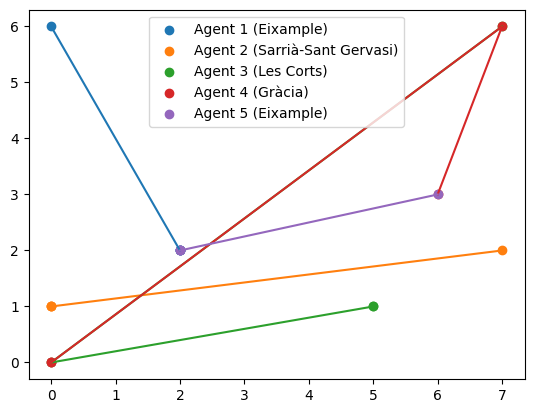

In [41]:
#Plot positions and wealth (NOT DONE, wanted to do it with the size of the circle) by district
positions = barcelona.datacollector.get_model_vars_dataframe()
#wealth= barcelona.datacollector.get_agent_vars_dataframe()  #create agent variable collector in the code
#wealth = wealth.reset_index()

def extract_position(row, agent_index):
    return row['Agent Positions'][agent_index]
for i in range(N):
    positions[f'Agent {i+1}'] = positions.apply(lambda row: extract_position(row, i), axis=1)

fig, ax = plt.subplots()
for i in range(N):
    agent_col = f'Agent {i+1}'
    district = positions['Agent Districts'][0][i]
    label = f"{agent_col} ({district})"
    ax.scatter(positions[agent_col].apply(lambda x: x[0]), positions[agent_col].apply(lambda x: x[1]), label=label)
    positions[f'Agent {i+1} X'] = [pos[i][0] for pos in positions['Agent Positions']]
    positions[f'Agent {i+1} Y'] = [pos[i][1] for pos in positions['Agent Positions']]

# each agent's trajectory
for i in range(N):
    ax.plot(positions[f'Agent {i+1} X'], positions[f'Agent {i+1} Y'])
ax.legend()
plt.show()



### ADD COMPLEXITY

The next step would be to add complexity to the model: 

- Hauríem de mapejar espaialment els districtes per tenir també les localitzacions i tot automatic i en proporció. 
- Hauríem de deixar que els agents es moguessin d'un districte a un altre. 
- Fer homeless status: agents que tinguin home: null, amb llista d'accions disponibles different.

- Finally, implement the NEEDS model.


Atur entre joves: https://ajuntament.barcelona.cat/joves/es/canal/pla-de-foment-de-locupacio-juvenil-2020-2023#:~:text=Seg%C3%BAn%20los%20datos%20del%20%C3%BAltimo,de%20un%2012%2C6%25.
https://ajuntament.barcelona.cat/dretssocials/sites/default/files/arxius-documents/resum_de_dades_de_lenquesta_a_la_joventut_de_barcelona_2020.pdf

Según los datos del último trimestre del año 2020:
- Paro juvenil en la población de 16 a 24 años: 29,9%, más del doble de la media de la ciudad, que es de un 12,6%.
- Falta probabilitat student or employed entre joves.

- Podria assignar l'atur dels agents (status: unemployed) per districte, per gènere, per edat, etc. De moment està fet per edat amb percentatges de dades d'internet orientatives. 

In [43]:

districtes = ['Gràcia', 'Sarrià-Sant Gervasi', 'Les Corts', 'Eixample']
gender2021 = pd.read_csv("OpenData/2021_Atur_per_sexe.csv")
gender2021 = gender2021[gender2021['Nom_Districte'].isin(districtes)]
pesatur = pd.read_csv("OpenData/2021_Pes_del_atur_registrat_sobre_poblacio_16_64_anys.csv") 
pesatur = pesatur[pesatur['Nom_Districte'].isin(districtes)]
pesatur.groupby('Nom_Districte')['Pes_atur'].mean()  #Aquí tinc la mitjana del pes d'atur de cada districte, però em surt molt baix :/

gendergrouped = gender2021.groupby(['Nom_Districte', 'Sexe'])
total_by_group = gendergrouped['Nombre'].sum()

#FINS AQUÍ PUC IMPRIMIR ELS PERCENTATGES DE DONES I HOMES EN ATUR A CADA DISTRICTE. 
# calcular el nombre total de persones en atur per cada districte
total_by_district = total_by_group.groupby('Nom_Districte').sum()

# calcular el percentatge de dones i homes en atur per cada districte
(total_by_group / total_by_district)



Nom_Districte        Sexe 
Eixample             Dones    0.520987
                     Homes    0.479013
Gràcia               Dones    0.527984
                     Homes    0.472016
Les Corts            Dones    0.531546
                     Homes    0.468454
Sarrià-Sant Gervasi  Dones    0.543167
                     Homes    0.456833
Name: Nombre, dtype: float64

# NEEDS MODEL

Ara afegim needs basant-nos en la Maslow's hierarchy: 
Els hauríem d'afegir a la classe agent com un aspecte més dels agents, ha de ser un diccionari de categories amb needs a dins, ja amb weights associats directament. 
Una funcio a model ha de fer que cadascú d'aquests needs tingui un NSL weight que decaigui a cada step t. De manera inversa, la urgencia. 
Per decidir la següent acció tindrem la expected SAT que donara el nivell de satisfaccio de l'agent que s'espera un cop empleni need n despres de fer a en temps t. 

- Physiological : food, shelter, sleep, health
- Safety: clothing, financial security, employment, education
- Belonging: family, friendship, intimacy
- Esteem: freedom, status. self-esteem


<img src=https://simplypsychology.org/wp-content/uploads/maslow-hierachy-of-needs-min-1536x1086.jpg width="600">

We need to take into account that the importance weight will decrease from the bottom to the top of the pyramid, and the decaying rate and initial value will be different for each individual need based on the age, status of the agent. 

Let's create a *Needs Dictionary* with all the categories, needs, and parameters.

In [44]:
#LIST OF NSL VALUES AT TIME T PERFECTO
#normal dictionary
needs = {
    'physiological': ['food', 'shelter', 'sleep', 'health'],
    'safety': ['clothing', 'financial security', 'employment'],
    'belonging': ['family', 'friendship', 'intimacy'],
    'esteem': ['freedom', 'status', 'self-esteem']
}
#nested dicitonary
needs = {
    'physiological': {
        'needs': ['food', 'shelter', 'sleep', 'health'],
        'weight': 0.9,
        'decaying': [ 0.8,  0.5,  0.7,  0.3 ],
        'initial':  0.9
    },
    'safety': {
        'needs': ['clothing', 'financial security', 'employment'],
        'weight': 0.6,
        'decaying': [ 10,  5,  7 ],
        'initial':  0.8
    },
    'belonging': {
        'needs': ['family', 'friendship', 'intimacy'],
        'weight': 0.4,
        'decaying': [ 0.3,  0.4,  0.2 ],
        'initial':  0.8
    },
    'esteem': {
        'needs': ['freedom', 'status', 'self-esteem'],
        'weight': 0.2,
        'decaying': [ 0.2,  0.1,  0.3],
        'initial':  0.7
    }
}

#needs['physiological']['decaying'][1]


Let's define the needs_list and actions_list, the columns and rows of the SAT matrix defining the Satisfaction expected from a certain pair of exectued action and need.

- Needs: food and water, shelter, sleep, clothing, health, financial security, employment, family, friendship, intimacy, freedom, status, self-esteem. 
- Actions: go home, go grocery, go work, go hospital, go shopping, go leisure. 

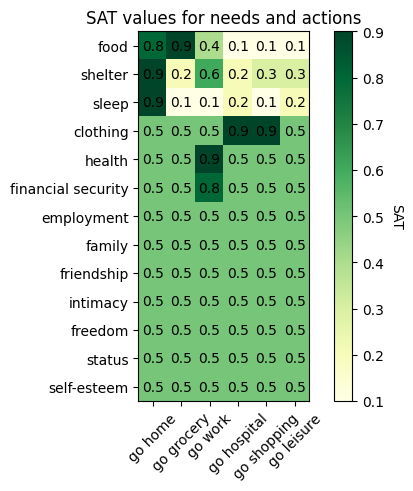

In [45]:

needs = ["food", "shelter", "sleep", "clothing", "health", "financial security", "employment", "family", "friendship", "intimacy", "freedom", "status", "self-esteem"]
actions = ["go home", "go grocery", "go work", "go hospital", "go shopping", "go leisure"]

#1ERA MANERA 
# Initialize the matrix with zeros
SAT_matrix = [[0.0 for _ in range(len(actions))] for _ in range(len(needs))]
for i, n in enumerate(needs):
    for j, a in enumerate(actions):
        if n == "food" and a == "go home":
            SAT_matrix[i][j] = 0.8
        elif n == "food" and a == "go grocery":
            SAT_matrix[i][j] = 0.9
        else:
            # Assign a default SAT value of 0.5 for all other pairs
            SAT_matrix[i][j] = 0.5
            
def get_SAT(n, a):
    i = needs.index(n)
    j = actions.index(a)
    return SAT_matrix[i][j]

#2NA MANERA
# Define the SAT values for each pair of need and action
SAT_values = [
    [0.8, 0.9, 0.4, 0.1, 0.1, 0.1],
    [0.9, 0.2, 0.6, 0.2, 0.3, 0.3],
    [0.9, 0.1, 0.1, 0.2, 0.1, 0.2],
    [0.5, 0.5, 0.5, 0.9, 0.9, 0.5],
    [0.5, 0.5, 0.9, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.8, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
]

# Create a matrix of SAT values
SAT_matrix = np.array(SAT_values)

# Create a heatmap of the SAT values
fig, ax = plt.subplots()
im = ax.imshow(SAT_matrix, cmap='YlGn')

ax.set_xticks(range(len(actions)))
ax.set_yticks(range(len(needs)))
ax.set_xticklabels(actions, rotation=45)
ax.set_yticklabels(needs)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("SAT", rotation=-90, va="bottom")
for i in range(len(needs)):
    for j in range(len(actions)):
        text = ax.text(j, i, SAT_matrix[i][j], ha="center", va="center", color="black")
ax.set_title("SAT values for needs and actions")
plt.show()


## INDIVIDUAL AND PERSONALIZED SAT MATRICES BY STATUS

In [ ]:
import numpy as np
# Dictionary of Sat matrices for each STATUS
SAT_retired = [
        [0.8, 0.9, 0.4, 0.9, 0.1, 0.1],
        [0.9, 0.2, 0.6, 0.2, 0.3, 0.3],
        [0.2, 0.1, 0.1, 0.2, 0.1, 0.1],
        [0.1, 0.3, 0.2, 0.1, 0.9, 0.3],
        [0.3, 0.1, 0.1, 0.8, 0.1, 0.1],
        [0.1, 0.1, 0.9, 0.1, 0.1, 0.1],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
    ]

SAT_student = [
        [0.8, 0.9, 0.4, 0.9, 0.1, 0.1],
        [0.9, 0.2, 0.6, 0.2, 0.3, 0.3],
        [0.2, 0.1, 0.1, 0.2, 0.1, 0.1],
        [0.1, 0.3, 0.2, 0.1, 0.9, 0.3],
        [0.3, 0.1, 0.1, 0.8, 0.1, 0.1],
        [0.1, 0.1, 0.9, 0.1, 0.1, 0.1],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
    ]
SAT_employed = [
        [0.8, 0.9, 0.4, 0.9, 0.1, 0.1],
        [0.9, 0.2, 0.6, 0.2, 0.3, 0.3],
        [0.2, 0.1, 0.1, 0.2, 0.1, 0.1],
        [0.1, 0.3, 0.2, 0.1, 0.9, 0.3],
        [0.3, 0.1, 0.1, 0.8, 0.1, 0.1],
        [0.1, 0.1, 0.9, 0.1, 0.1, 0.1],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
    ]
SAT_unemployed = [
        [0.8, 0.9, 0.4, 0.9, 0.1, 0.1],
        [0.9, 0.2, 0.6, 0.2, 0.3, 0.3],
        [0.2, 0.1, 0.1, 0.2, 0.1, 0.1],
        [0.1, 0.3, 0.2, 0.1, 0.9, 0.3],
        [0.3, 0.1, 0.1, 0.8, 0.1, 0.1],
        [0.1, 0.1, 0.9, 0.1, 0.1, 0.1],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.9, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
    ]

SAT_matrices = {
    'retired': np.array(SAT_retired),
    'student': np.array(SAT_student),
    'employed': np.array(SAT_employed),
    'unemployed': np.array(SAT_unemployed)
}

SAT_matrices['retired']


We already have a code version where the nsl and urg values for every agent are recollected.
- We should be able to visualize this in the future: how they decay when time goes one. FIRST FIX THE RECOLLECTION OF THE NSL DICT.
- The next version of the code takes into account that the executed actions satisfied 0.2* the SAt value associated. PARAMETER TUNING OF THE SAT MATRICES BY STATUS AND THESE PROPORTION. 
- For instance, Hauria de fer que si l'edat es adolescencia, el decaying the friends sigui més fort. Si l'edat es elevada, el decay de salud també, etc. 
- Decide_action: The function a[t] will take the maximum value of the list of scores computed for all the set of acctions of the corresopnding agent. Each element of the list will be computed as the sum of the multiplication of the sat value of that action for all the need by the urg of that need, and each one for the weight importance of the category of the need. Finally we extract the name of the corresponding highest score. 
- PSEUDO CODE:
for category in needs[category]
    for need in needs: 
        SAT (a, need)* urg(need)* Imp()

In [47]:
#Dictionary of sat matrices with dictionary of actions for each status. 

needs_list = ["food", "shelter", "sleep", "clothing", "health", "financial security", "employment", "education", "family", "friendship", "intimacy", "freedom", "status", "self-esteem"]
   
actions_dict = {
        'retired': ["go_home", "go_grocery", "go_hospital", "go_shopping", "go_leisure"],
        'employed': ["go_home", "go_grocery", "go_work", "go_hospital", "go_shopping", "go_leisure"],
        'unemployed': ["go_home", "go_grocery", "go_school", "go_hospital", "go_shopping", "go_leisure"],
        'student': ["go_home", "go_grocery","go_school", "go_hospital", "go_shopping", "go_leisure"]
        }
    
SAT_matrices = {}

# Loop through each status category in actions_dict
for status, actions in actions_dict.items():
    # Initialize the SAT matrix with zeros
    SAT_matrix = [[0.0 for _ in range(len(actions))] for _ in range(len(needs_list))]
    for i, need in enumerate(needs_list):
        for j, action in enumerate(actions):
            # Assign specific SAT values based on need-action pairs
            if need == "food" and action == "go_home":
                if status == "retired":
                    SAT_matrix[i][j] = 0.8
                elif status == "student":
                    SAT_matrix[i][j] = 0.7
                else:
                    SAT_matrix[i][j] = 0.5
            elif need == "food" and action == "go_grocery":
                SAT_matrix[i][j] = 0.9

            elif need == "health" and action == "go_hospital":
                if status == "retired":
                    SAT_matrix[i][j] = 0.9
                else:
                    SAT_matrix[i][j] = 0.6
            elif need == "friendship" and action == "go_leisure":
                if status == "student":
                    SAT_matrix[i][j] = 0.8
                else:
                    SAT_matrix[i][j] = 0.4
            else:
                # Assign a default SAT value of 0.5 for all other pairs
                SAT_matrix[i][j] = 0.5
    # Add the SAT matrix to the dictionary with the status category as the key
    SAT_matrices[status] = SAT_matrix

SAT_matrices['retired']

def get_scores(self):
        scores = []
        for action in actions_list:
            score = 0
            for category, category_data in self.needs.items():
                weight = category_data['weight']
                for need, nsl, urgency in zip(category_data['needs'], self.nsl[category], self.urg[category]):
                    i =  actions_list.index(action)
                    j =  needs_list.index(need)
                    sat = self.sat[j][i]
                    score += sat * urgency * weight
            scores.append(score)
        return scores

Next version of the code already has the *decide_action* function implemented so agents choose the action corresponding on the status. Nevertheless, employed and students start their autonomous behaviour when they get out of school at 17. So the behaviour of the agents is determined by time in the step part of the *CityModel* class up to the corresponding time. All agents have a fixed sleep schedule.

ISSUES: 
- Autonomous behaviour of the unemployed and retired? Define a well-tuned SAT, and some predetermined behaviour? 
- Maybe hunger and sleep should decay differently, in a ciclic way?

- Feature tuning SAT matrices and the nsl refill by the 20% of the SAT value.  LIMITANT NUMBER AT 1. 
- Add actions to each status set. 
- Grid visualization and nsl visualization. 

- ara mateix les LOCATIONS són 0 determinants pel model!



In [50]:
import mesa
import numpy as np
from data import probabilidades_por_distrito, district_wealth, actions_list, needs_list, assign_district, SAT_matrix, needs
from typing import Collection, Dict, List, Tuple

class Apo_Agent(mesa.Agent):
    needs: Dict[str, List[str]] #Diccionari needs principal definit, res del nested de dins.
    sat: Dict[str, List[List[float]]] #Diccionari sat matrices deppending on status

    def __init__(self, unique_id, model, district, needs: Dict[str, List[str]], sat:  Dict[str, List[List[float]]]): #
        super().__init__(unique_id, model)
        self.home = None
        self.age = None
        self.district = district
        self.wealth = None 
        self.status = None
        self.gender = None
        self.needs = needs
        self.nsl = {category: [self.needs[category]['initial']] * len(self.needs[category]['needs']) for category in self.needs}
        self.urg = {category: [1-self.needs[category]['initial']] * len(self.needs[category]['needs']) for category in self.needs}
        self.sat = sat

    def update_nsl_and_urg(self):
        for category in self.needs:
            decay = self.needs[category]['decaying']
            for i in range(len(self.nsl[category])):
                self.nsl[category][i] *= decay[i]
                #print(self.nsl)
                self.urg[category][i] = 1 - self.nsl[category][i]
    
    def decide_action(self):
        scores = []
        for action in actions_list:
            score = 0
            for category, category_data in self.needs.items():
                weight = category_data['weight']
                for need, urgency in zip(category_data['needs'], self.urg[category]):
                    i =  actions_list.index(action)
                    j =  needs_list.index(need)
                    #cambios lele
                    #for status in ['retired', 'employed', 'unemployed', 'student']:
                        #sat_matrix = self.sat[status]

                    #sat = sat_matrix[j][i]
                    sat = self.sat[j][i]
                    score += sat * urgency * weight
            scores.append(score)

        max_score_idx = scores.index(max(scores))
        max_score_action = actions_list[max_score_idx]

        #update nsl values with the corresponding proportion of the SAT column of the action (with maximum value 1)
        for category, category_data in self.needs.items():
            for i, need in enumerate(category_data['needs']):
                j = max_score_idx
                self.nsl[category][i] = min(self.nsl[category][i] + 0.2* self.sat[i][j], 1.0000)
                #self.nsl[category][i] += 0.2* self.sat[i][j] #sense límit a 1

        return max_score_action

    def assign_income(self):
        district_income_data = district_wealth[self.district]
        income = district_income_data['Import_Euros'].tolist()
        income_probs = income / district_income_data['Import_Euros'].sum()
        prob = income_probs.tolist()
        self.wealth = np.random.choice(income, p=prob)

    def assign_age_and_status(self):
        probabilidades_edades = probabilidades_por_distrito[self.district]
        edades = list(probabilidades_edades.keys())
        probabilidades = list(probabilidades_edades.values())
        self.age = np.random.choice(edades, p=probabilidades)

        if self.age <= 16:
            self.status = "student"
        elif 16 < self.age <=22:
            self.status = np.random.choice(["student", "employed", "unemployed"], p=[0.4, 0.3, 0.3]) #un 30% de prob d'estar en atur
        elif 22 < self.age <= 67:
            self.status = np.random.choice([ "employed", "unemployed"])
        else: self.status = "retired"

    def go_work(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['work']))
    
    def go_leisure(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['leisure']))

    def go_home(self):
        self.model.districts[self.district].place_agent(self, self.home)

    def go_school(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['school']))

    def go_grocery(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['grocery']))

    def go_hospital(self):
        self.model.districts[self.district].place_agent(self, self.random.choice(self.model.districts[self.district].locations['hospital']))

    def step(self):
        #print(self.needs['physiological']['weight'])

        time = self.model.schedule.time % 24

        #Segons el temps i l'status, manipulo els nsl values 
        #if 0 <= time < 8: 
        #    if self.status == ''

        #Every step we update the nsl and urg scores

        #self.get_scores()
        #print(self.get_scores())
        #Decide action with the highest score and Update nsl values related with that action with SAT.

        if 8 <= time < 15: 
            self.update_nsl_and_urg()
            getattr(self, self.decide_action())() 
            chosenaction = self.decide_action()
            #print(chosenaction)
            #getattr(self, chosen_action)()   # és com fer agent.chosenaction
            print(" At time " + str(time + 8) + " the agent " + str(self.status) + " decides " + str((chosenaction))+ " to the position " + str(self.pos) + " with nsl " + str(self.nsl))

        #print(self.nsl)
        #print(self.urg)
        #print(self.sat)
from city import DistrictGrid, gracia, sarria_stgervasi, eixample, les_corts

N = 5

class CityModel(mesa.Model):
    name: str
    districts: Dict[str, DistrictGrid]
    
    def __init__(self, name: str, districts: Collection[DistrictGrid], N) -> None:
        self.num_agents = N
        self.name = name
        self.districts = {dist.name: dist for dist in districts}
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            ag = Apo_Agent(i, self, district = assign_district(), needs = needs, sat = SAT_matrix) 
            ag.home = self.districts[ag.district].locations['houses'][i]
            ag.assign_age_and_status()
            ag.assign_income()
            self.schedule.add(ag)
            
        self.datacollector = mesa.DataCollector(
        model_reporters={"Agent Positions": lambda m: [a.pos for a in m.schedule.agents]},
        agent_reporters={
                "nsl": lambda a: a.nsl,
                "urg": lambda a: a.urg,
            })

    def step(self):
        time = self.schedule.time % 24
        print("Són les " + str(time + 8))
        if time == 0: 
            for agent in self.schedule.agents:
                self.districts[agent.district].place_agent(agent, agent.home)
                #print(agent.pos)

        # Schedule agents to go to work or school in the morning
        if 0 < time < 8:
        
            for agent in self.schedule.agents:
                #print(agent.pos)
                if agent.status == "Student": 
                    agent.go_school()
                elif agent.status == "Employed":
                    agent.go_work()
                else:  #agent.status == "Unemployed" or "Retired"  AIXÒ HO HAURE DE CANVIAR MÉS ENDAVANT
                    agent.go_home()
        """          
        if 8 <= time < 15: 
            for agent in self.schedule.agents:
                agent.go_leisure()
        """
        if 15 <= time <= 23:
            for agent in self.schedule.agents:
                agent.go_home()
        
        #when a month has passed, mensuality is given to the agents
        if self.schedule.time % 672 == 0:
            for agent in self.schedule.agents:
                agent.wealth += agent.wealth
        
        #when a year has passed, agents grow old
        if self.schedule.time % 8064 == 0:
            for agent in self.schedule.agents:
                agent.age += 1
                
        for i in range(self.num_agents):
            agent = self.schedule.agents[i]
            print( "Position of "+ str(agent.unique_id) +" at time " + str(time + 8) + " is " + str(agent.pos) + " in district " + str(agent.district) + " with age " + str(agent.age) + " and status " + str(agent.status))

        self.datacollector.collect(self)
        self.schedule.step()
    

if __name__ == '__main__':

    lista_distritos = [gracia, les_corts, eixample, sarria_stgervasi] 
    
    #GENERATE HOUSES FOR N AGENTS
    for district in lista_distritos:
        district.locations['houses'] = district.generate_tuples(N, (0, 9), (0, 9))

    barcelona = CityModel('Barcelona', lista_distritos, N)
    pass

for i in range(10):
    barcelona.step()


Són les 8
Position of 0 at time 8 is (4, 5) in district Sarrià-Sant Gervasi with age 66 and status employed
Position of 1 at time 8 is (0, 5) in district Gràcia with age 69 and status retired
Position of 2 at time 8 is (0, 7) in district Sarrià-Sant Gervasi with age 78 and status retired
Position of 3 at time 8 is (0, 9) in district Sarrià-Sant Gervasi with age 16 and status student
Position of 4 at time 8 is (4, 0) in district Les Corts with age 58 and status employed
Són les 9
Position of 0 at time 9 is (4, 5) in district Sarrià-Sant Gervasi with age 66 and status employed
Position of 1 at time 9 is (0, 5) in district Gràcia with age 69 and status retired
Position of 2 at time 9 is (0, 7) in district Sarrià-Sant Gervasi with age 78 and status retired
Position of 3 at time 9 is (0, 9) in district Sarrià-Sant Gervasi with age 16 and status student
Position of 4 at time 9 is (4, 0) in district Les Corts with age 58 and status employed
Són les 10
Position of 0 at time 10 is (4, 5) in dis

- Also, homeless agents must be added to the model. The probabilities for each district are extracted below, with external data from this page: https://www.arrelsfundacio.org/es/aumentan-a-1-231-las-personas-que-viven-en-la-calle-en-barcelona/

In [3]:
#PROBABILITATS HOMELESS PER DISTRICTE
import pandas as pd

districtes = ['Gràcia', 'Sarrià-Sant Gervasi', 'Les Corts', 'Eixample']
edat2020 = pd.read_csv("OpenData/2020_ine_edat_any_a_any_per_sexe.csv")
edat2020 = edat2020[edat2020['Nom_Districte'].isin(districtes)]
edat2020['Edat'] = edat2020['Edat_any_a_any'].str.extract('(\d+)').astype(int)
total_people = edat2020.groupby(['Nom_Districte'])['Nombre'].sum()
total_people
homeless_per_district = [297, 32, 43, 34]
prob_homeless = homeless_per_district / total_people * 100
prob_homeless

Nom_Districte
Eixample               0.109865
Gràcia                 0.025887
Les Corts              0.052101
Sarrià-Sant Gervasi    0.022533
Name: Nombre, dtype: float64

# REGULATIVE ENVIRONMENT

The regulative environment will be set using the *Institutional Grammar 2.0* tool, which parses institutional statements into the *ADICO* syntax: the Attribute field indicates to whom the norm or rule applies; the Deontic indicates whether it is a prohibition, permission or obligation; the aIm field indicates what action or outcome the deontic applies to; the Condition field indicates under what circumstances the statement applies, and the Or.Else field indicates any consequences for detected violations. 
